## Importing Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
#plt.style.use('fivethirtyeight')
from pyspark.context import SparkContext
from pyspark.sql.context import SQLContext
from pyspark.sql.session import SparkSession
sc=SparkContext()
sqlContext=SQLContext(sc)
spark=SparkSession(sc)
from pyspark.sql.functions import col,split, regexp_extract,to_timestamp,year, month, hour, minute, second,date_format
import re #Regular expressions for extracting the features for our project
import glob #The glob function in Python allows you to retrieve a list of file paths that match a specified pattern.


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/08/30 00:51:53 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/08/30 00:51:54 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
23/08/30 00:51:54 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.
/Users/arpit/anaconda3/lib/python3.10/site-packages/pyspark/sql/context.py:112: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


## Reading the Log Files

In [2]:
#sc.stop()

In [3]:
log_folder = "nginx"  # "log" folder contains all the log data thus giving its path
#Glob is commonly used to search for files and directories in a directory structure based on specific criteria.
raw_data_files=glob.glob("nginx/*.gz") #(glob Stands for 'Global')
raw_data_files

['nginx/access.log-20230215.gz',
 'nginx/proxy.log-20230214.gz',
 'nginx/proxy.log-20230220.gz',
 'nginx/access.log-20230221.gz',
 'nginx/error.log-20230220.gz',
 'nginx/error.log-20230214.gz',
 'nginx/error.log-20230221.gz',
 'nginx/error.log-20230215.gz',
 'nginx/access.log-20230214.gz',
 'nginx/proxy.log-20230215.gz',
 'nginx/proxy.log-20230221.gz',
 'nginx/access.log-20230220.gz',
 'nginx/access.log-20230219.gz',
 'nginx/proxy.log-20230218.gz',
 'nginx/error.log-20230218.gz',
 'nginx/error.log-20230219.gz',
 'nginx/access.log-20230218.gz',
 'nginx/proxy.log-20230219.gz',
 'nginx/error.log-20230222.gz',
 'nginx/error.log-20230216.gz',
 'nginx/access.log-20230213.gz',
 'nginx/proxy.log-20230216.gz',
 'nginx/access.log-20230217.gz',
 'nginx/proxy.log-20230222.gz',
 'nginx/proxy.log-20230217.gz',
 'nginx/error.log-20230213.gz',
 'nginx/access.log-20230216.gz',
 'nginx/access.log-20230222.gz',
 'nginx/error.log-20230217.gz',
 'nginx/proxy.log-20230213.gz']

## Printing the scema

In [4]:
log_df1=spark.read.text(raw_data_files)
log_df1.printSchema()

root
 |-- value: string (nullable = true)



In [6]:
log_df1.show(10,truncate=False)

+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|value                                                                                                                                                                                                                                                                                                                        |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|143.244.50.172 - - [16/Feb/2023:03:28:4

23/08/30 01:58:33 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 1004697 ms exceeds timeout 120000 ms
23/08/30 01:58:34 WARN SparkContext: Killing executors is not supported by current scheduler.
23/08/30 01:58:38 WARN Executor: Issue communicating with driver in heartbeater
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:101)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:85)
	at org.apache.spark.storage.BlockManagerMaster.registerBlockManager(BlockManagerMaster.scala:80)
	at org.apache.spark.storage.BlockManager.reregister(BlockManager.scala:641)
	at org.apache.spark.executor.Executor.reportHeartBeat(Executor.scala:1111)
	at org.apache.spark.executor.Executor.$anonfun$heartbeater$1(Executor.scala:244)
	at s

In [ ]:
# 198.20.69.98 - - [16/Feb/2023:07:26:00 +0530] "GET / HTTP/1.1" 2001 15952 "-" "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/98.0.4758.102 Safari/537.36

In [65]:
log_df1.head(5)

[Row(Ip_address='143.244.50.172', HTTP request line='GET', user_agent='/config/getuser?index=0', protocol='HTTP/1.1', HTTP status code='143', Size of the response in bytes='248', response_time=0, year='2023', month='Feb', date='16', hour='03', minute='28', seconds='45'),
 Row(Ip_address='164.90.235.116', HTTP request line='GET', user_agent='/', protocol='HTTP/1.1', HTTP status code='164', Size of the response in bytes='5952', response_time=0, year='2023', month='Feb', date='16', hour='04', minute='11', seconds='34'),
 Row(Ip_address='66.249.69.126', HTTP request line='GET', user_agent='/robots.txt', protocol='HTTP/1.1', HTTP status code='249', Size of the response in bytes='146', response_time=0, year='2023', month='Feb', date='16', hour='04', minute='39', seconds='52'),
 Row(Ip_address='66.249.69.126', HTTP request line='GET', user_agent='/assets/img/favicon.png', protocol='HTTP/1.1', HTTP status code='249', Size of the response in bytes='491', response_time=0, year='2023', month='Feb

## Using RE for Extracting the features of log data

In [8]:
ip_pattern = r'(^\S+\.[\S+\.]+\S+)\s'
timestamp_pattern = r'\[(\d{2}/\w+/\d{4}:\d{2}:\d{2}:\d{2} \+\d{4})\]'
request_pattern = r'\"(\S+)\s(\S+)\s*(\S*)\"'
status_pattern = r'(\d{3})'
size_pattern = r'\s(\d+) "'
user_agent_pattern = r'"([^"]+)"'
protocol_pattern = r'HTTP/([\d.]+)'
browser_pattern = r'"([^"]+)"$'

In [9]:
log_df1 = log_df1.select(
                         regexp_extract(col("value"), ip_pattern, 1).alias("Ip_address"),
                         regexp_extract(col("value"), timestamp_pattern, 1).alias("timestamp"),
                         regexp_extract(col("value"), request_pattern, 1).alias("HTTP request line"),
                         regexp_extract(col("value"), request_pattern, 2).alias("user_agent"),
                         regexp_extract(col("value"), request_pattern, 3).alias("protocol"),
                         regexp_extract(col("value"), status_pattern, 1).alias("HTTP status code"),
                         regexp_extract(col("value"), size_pattern, 1).alias("Size of the response in bytes"),
                        )
log_df1 = log_df1.withColumn("timestamp", to_timestamp(col("timestamp"), "dd/MMM/yyyy:HH:mm:ss Z"))
log_df1 = log_df1.withColumn("response_time", (col("timestamp").cast("long") - col("timestamp").cast("long")).cast("int"))

log_df1 = log_df1.withColumn("year", col("timestamp").substr(1, 4))
log_df1 = log_df1.withColumn("month", date_format(col("timestamp"), "MMM"))
log_df1 = log_df1.withColumn("date", col("timestamp").substr(9, 2))
log_df1 = log_df1.withColumn("hour", col("timestamp").substr(12, 2))
log_df1 = log_df1.withColumn("minute", col("timestamp").substr(15, 2))
log_df1 = log_df1.withColumn("seconds", col("timestamp").substr(18, 2))

In [10]:
log_df1 = log_df1.drop("timestamp")
## Droping the timestamp column

In [11]:
log_pandas_df = log_df1.toPandas() #Converting it into Pandas dataframe for better visualization
log_pandas_df

,Ip_address,HTTP request line,user_agent,protocol,HTTP status code,Size of the response in bytes,response_time,year,month,date,hour,minute,seconds
0,143.244.50.172,GET,/config/getuser?index=0,HTTP/1.1,143,248,0.0,2023,Feb,16,03,28,45
1,164.90.235.116,GET,/,HTTP/1.1,164,5952,0.0,2023,Feb,16,04,11,34
2,66.249.69.126,GET,/robots.txt,HTTP/1.1,249,146,0.0,2023,Feb,16,04,39,52
3,66.249.69.126,GET,/assets/img/favicon.png,HTTP/1.1,249,491,0.0,2023,Feb,16,04,39,52
4,185.221.219.172,GET,/.git/config,HTTP/1.1,185,548,0.0,2023,Feb,16,05,06,47
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6213,,GET,/sitemaps.xml,HTTP/1.1,202,,NaN,None,None,None,None,None,None
6214,,GET,/robots.txt,HTTP/1.1,202,,NaN,None,None,None,None,None,None
6215,,GET,/favicon.ico,HTTP/1.1,202,,NaN,None,None,None,None,None,None
6216,,GET,/owa/auth/logon.aspx?url=https%3a%2f%2f1%2fecp%2f,HTTP/1.1,202,,NaN,None,None,None,None,None,None


In [12]:
log_pandas_df=log_pandas_df.dropna()
log_pandas_df

,Ip_address,HTTP request line,user_agent,protocol,HTTP status code,Size of the response in bytes,response_time,year,month,date,hour,minute,seconds
0,143.244.50.172,GET,/config/getuser?index=0,HTTP/1.1,143,248,0.0,2023,Feb,16,03,28,45
1,164.90.235.116,GET,/,HTTP/1.1,164,5952,0.0,2023,Feb,16,04,11,34
2,66.249.69.126,GET,/robots.txt,HTTP/1.1,249,146,0.0,2023,Feb,16,04,39,52
3,66.249.69.126,GET,/assets/img/favicon.png,HTTP/1.1,249,491,0.0,2023,Feb,16,04,39,52
4,185.221.219.172,GET,/.git/config,HTTP/1.1,185,548,0.0,2023,Feb,16,05,06,47
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5731,154.12.227.174,POST,/core/.env,HTTP/1.1,154,146,0.0,2023,Feb,19,02,48,08
5732,154.12.227.174,GET,/core/.env,HTTP/1.1,154,146,0.0,2023,Feb,19,02,48,10
5733,154.12.227.174,POST,/,HTTP/1.1,154,150,0.0,2023,Feb,19,02,48,12
5734,154.12.227.174,POST,/core/.env,HTTP/1.1,154,146,0.0,2023,Feb,19,02,48,13


## Checking the Null Values in a Dataframe

In [13]:
log_pandas_df.isnull().sum()

Ip_address                       0
HTTP request line                0
user_agent                       0
protocol                         0
HTTP status code                 0
Size of the response in bytes    0
response_time                    0
year                             0
month                            0
date                             0
hour                             0
minute                           0
seconds                          0
dtype: int64

## Addition of 'Total no of requests'

In [14]:
log_pandas_df['No of Requests']=log_pandas_df.groupby(['Ip_address'])['user_agent'].transform('count')
log_pandas_df

/var/folders/rs/sxmf7m5s52s2h51r_1p5nwgh0000gn/T/ipykernel_23473/2344694714.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  log_pandas_df['No of Requests']=log_pandas_df.groupby(['Ip_address'])['user_agent'].transform('count')


,Ip_address,HTTP request line,user_agent,protocol,HTTP status code,Size of the response in bytes,response_time,year,month,date,hour,minute,seconds,No of Requests
0,143.244.50.172,GET,/config/getuser?index=0,HTTP/1.1,143,248,0.0,2023,Feb,16,03,28,45,62
1,164.90.235.116,GET,/,HTTP/1.1,164,5952,0.0,2023,Feb,16,04,11,34,5
2,66.249.69.126,GET,/robots.txt,HTTP/1.1,249,146,0.0,2023,Feb,16,04,39,52,20
3,66.249.69.126,GET,/assets/img/favicon.png,HTTP/1.1,249,491,0.0,2023,Feb,16,04,39,52,20
4,185.221.219.172,GET,/.git/config,HTTP/1.1,185,548,0.0,2023,Feb,16,05,06,47,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5731,154.12.227.174,POST,/core/.env,HTTP/1.1,154,146,0.0,2023,Feb,19,02,48,08,6
5732,154.12.227.174,GET,/core/.env,HTTP/1.1,154,146,0.0,2023,Feb,19,02,48,10,6
5733,154.12.227.174,POST,/,HTTP/1.1,154,150,0.0,2023,Feb,19,02,48,12,6
5734,154.12.227.174,POST,/core/.env,HTTP/1.1,154,146,0.0,2023,Feb,19,02,48,13,6


## Encoding IPaddress

In [15]:
# Function to convert IP address to numerical value
import ipaddress
def convert_ip_to_numeric(ip_str):
    ip = ipaddress.ip_address(ip_str)
    return int(ip)
    

# Apply the conversion function to the entire column
log_pandas_df['Ip_address'] = log_pandas_df['Ip_address'].apply(convert_ip_to_numeric)
log_pandas_df

/var/folders/rs/sxmf7m5s52s2h51r_1p5nwgh0000gn/T/ipykernel_23473/2713326293.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  log_pandas_df['Ip_address'] = log_pandas_df['Ip_address'].apply(convert_ip_to_numeric)


,Ip_address,HTTP request line,user_agent,protocol,HTTP status code,Size of the response in bytes,response_time,year,month,date,hour,minute,seconds,No of Requests
0,2415145644,GET,/config/getuser?index=0,HTTP/1.1,143,248,0.0,2023,Feb,16,03,28,45,62
1,2757421940,GET,/,HTTP/1.1,164,5952,0.0,2023,Feb,16,04,11,34,5
2,1123632510,GET,/robots.txt,HTTP/1.1,249,146,0.0,2023,Feb,16,04,39,52,20
3,1123632510,GET,/assets/img/favicon.png,HTTP/1.1,249,491,0.0,2023,Feb,16,04,39,52,20
4,3118324652,GET,/.git/config,HTTP/1.1,185,548,0.0,2023,Feb,16,05,06,47,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5731,2584535982,POST,/core/.env,HTTP/1.1,154,146,0.0,2023,Feb,19,02,48,08,6
5732,2584535982,GET,/core/.env,HTTP/1.1,154,146,0.0,2023,Feb,19,02,48,10,6
5733,2584535982,POST,/,HTTP/1.1,154,150,0.0,2023,Feb,19,02,48,12,6
5734,2584535982,POST,/core/.env,HTTP/1.1,154,146,0.0,2023,Feb,19,02,48,13,6


## Encoding Other Categorical Column

In [16]:
from sklearn.preprocessing import LabelEncoder
# Apply Label Encoding to the required column
label_encoder=LabelEncoder()
log_pandas_df['HTTP request line'] = label_encoder.fit_transform(log_pandas_df['HTTP request line'])
log_pandas_df['protocol'] = label_encoder.fit_transform(log_pandas_df['protocol'])
log_pandas_df['user_agent'] = label_encoder.fit_transform(log_pandas_df['protocol'])
log_pandas_df['month'] = label_encoder.fit_transform(log_pandas_df['month'])

log_pandas_df

/var/folders/rs/sxmf7m5s52s2h51r_1p5nwgh0000gn/T/ipykernel_23473/1393602270.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  log_pandas_df['HTTP request line'] = label_encoder.fit_transform(log_pandas_df['HTTP request line'])
/var/folders/rs/sxmf7m5s52s2h51r_1p5nwgh0000gn/T/ipykernel_23473/1393602270.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  log_pandas_df['protocol'] = label_encoder.fit_transform(log_pandas_df['protocol'])
/var/folders/rs/sxmf7m5s52s2h51r_1p5nwgh0000gn/T/ipykernel_23473/1393602

,Ip_address,HTTP request line,user_agent,protocol,HTTP status code,Size of the response in bytes,response_time,year,month,date,hour,minute,seconds,No of Requests
0,2415145644,4,6,6,143,248,0.0,2023,0,16,03,28,45,62
1,2757421940,4,6,6,164,5952,0.0,2023,0,16,04,11,34,5
2,1123632510,4,6,6,249,146,0.0,2023,0,16,04,39,52,20
3,1123632510,4,6,6,249,491,0.0,2023,0,16,04,39,52,20
4,3118324652,4,6,6,185,548,0.0,2023,0,16,05,06,47,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5731,2584535982,7,6,6,154,146,0.0,2023,0,19,02,48,08,6
5732,2584535982,4,6,6,154,146,0.0,2023,0,19,02,48,10,6
5733,2584535982,7,6,6,154,150,0.0,2023,0,19,02,48,12,6
5734,2584535982,7,6,6,154,146,0.0,2023,0,19,02,48,13,6


## Distribution of each attribute

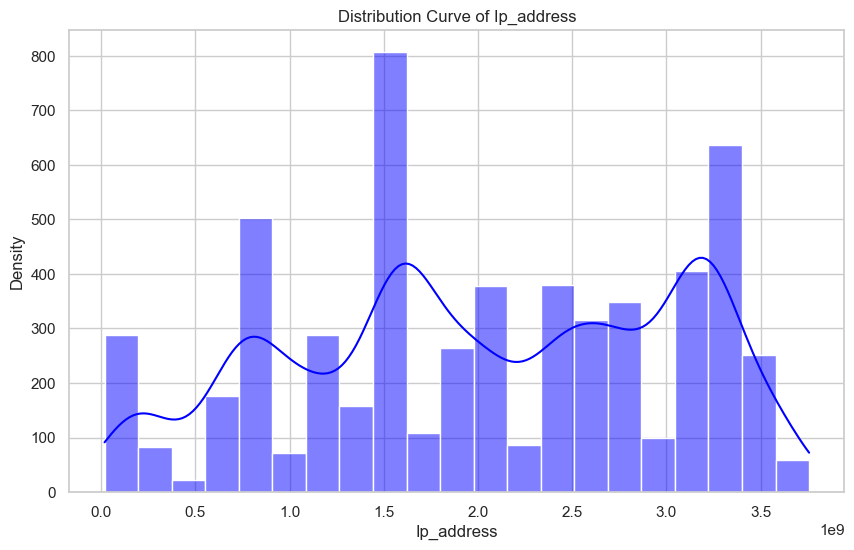

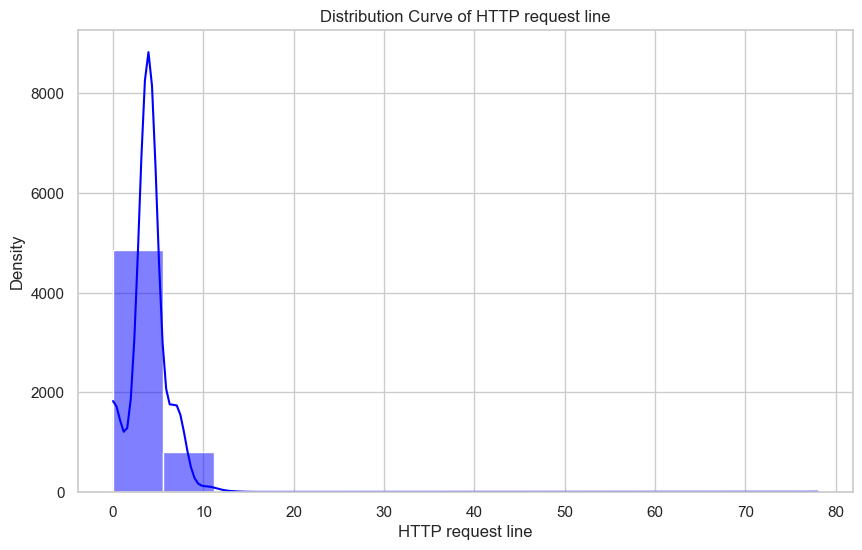

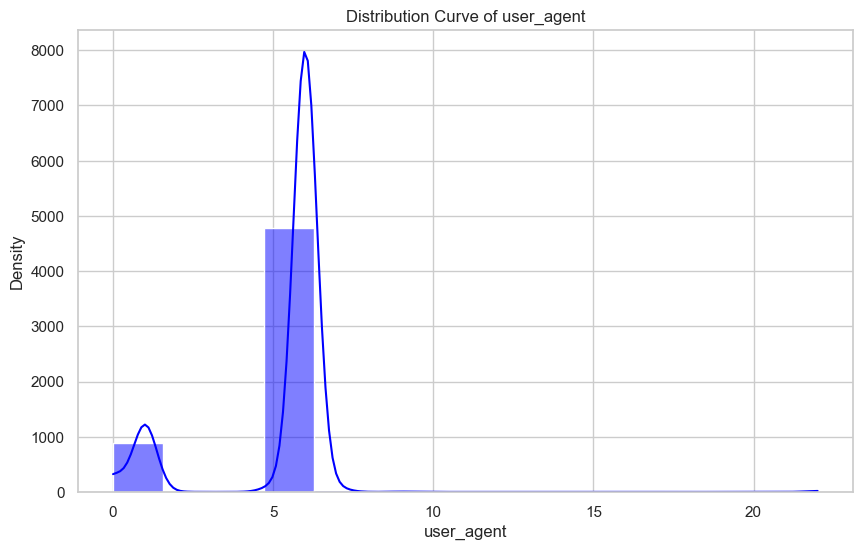

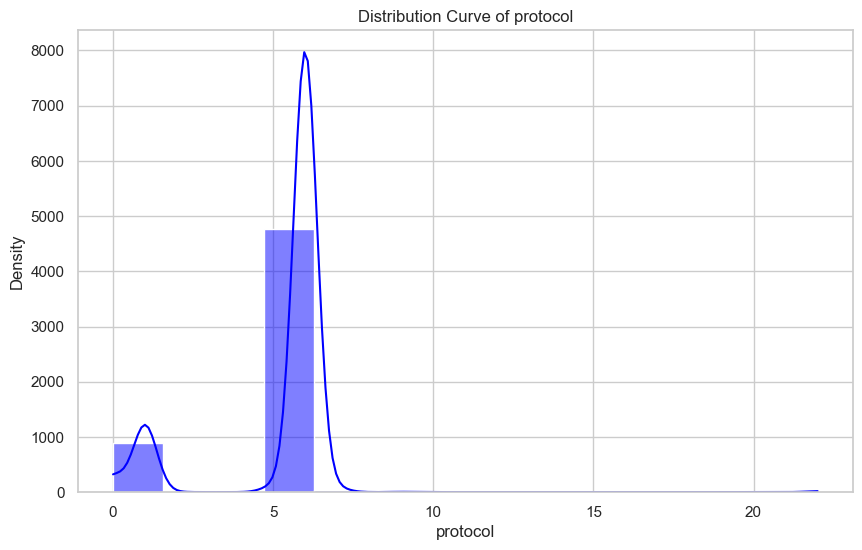

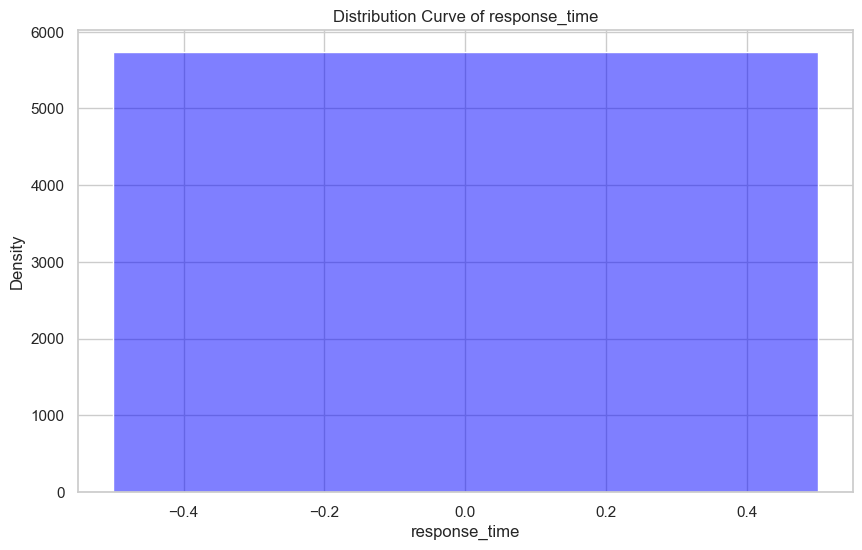

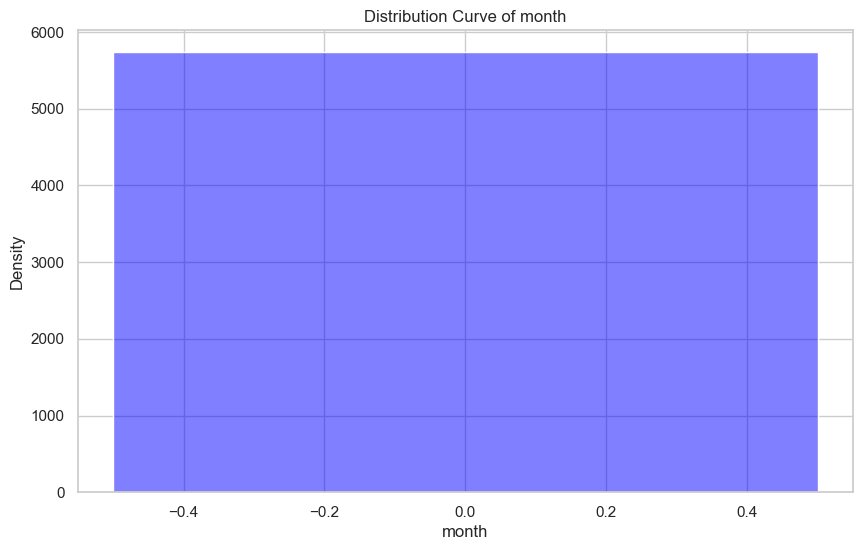

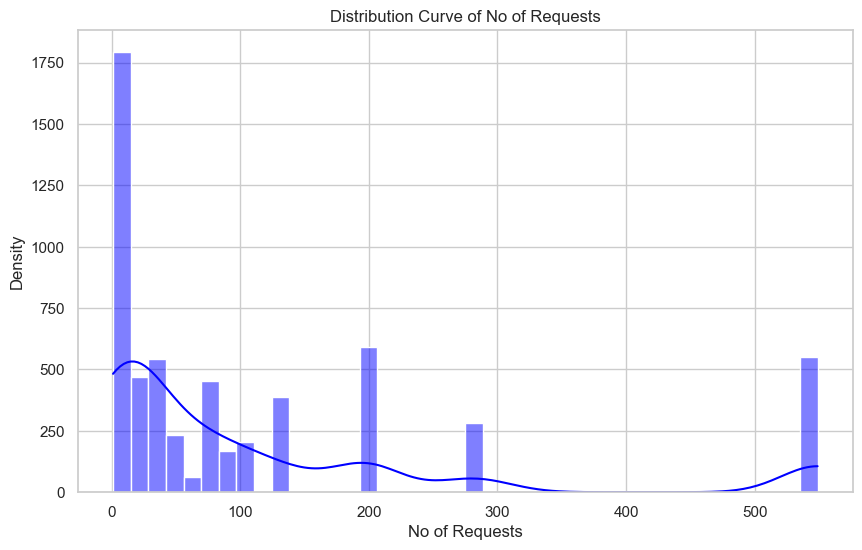

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


sns.set(style="whitegrid")

numerical_columns = log_pandas_df.select_dtypes(include=[np.number])

for column in numerical_columns.columns:
    plt.figure(figsize=(10, 6))
    sns.histplot(log_pandas_df[column], kde=True, color='blue')
    
    plt.title(f"Distribution Curve of {column}")
    plt.xlabel(column)
    plt.ylabel("Density")
    
    plt.show()


## DBSCAN Clusturing for finding Anomaly and Label data

In [18]:
import numpy as np
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
normalized_data = scaler.fit_transform(log_pandas_df)

best_eps = None
best_min_samples = None
best_score = -1

for eps in np.arange(0.5,1.5): 
    for min_samples in range(2, 10): 
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(normalized_data)
        
        if len(set(labels)) > 1:  
            score = silhouette_score(normalized_data, labels)
            if score > best_score:
                best_score = score
                best_eps = eps
                best_min_samples = min_samples

print(f"Best Silhouette Score: {best_score:.3f}")
print(f"Best eps: {best_eps}")
print(f"Best min_samples: {best_min_samples}")


Best Silhouette Score: 0.133
Best eps: 0.5
Best min_samples: 2


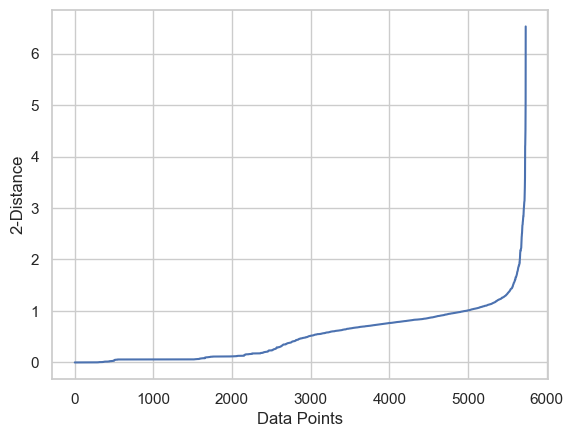

In [19]:
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

# Calculate the k-distance graph
k_distance = 2
neigh = NearestNeighbors(n_neighbors=k_distance)
neigh.fit(normalized_data)
distances, _ = neigh.kneighbors()

distances = np.sort(distances, axis=0)
plt.plot(distances[:, -1])
plt.xlabel("Data Points")
plt.ylabel(f"{k_distance}-Distance")
plt.show()


In [20]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

selected_columns = ['Ip_address', 'HTTP request line', 'user_agent', 'protocol', 'HTTP status code',
                    'Size of the response in bytes', 'response_time', 'year', 'month', 'date', 'hour',
                    'minute', 'seconds', 'No of Requests']

# Create a subset DataFrame with selected columns
data_subset = log_pandas_df[selected_columns]

# Normalize the data using StandardScaler
scaler = StandardScaler()
normalized_data = scaler.fit_transform(data_subset)

# Instantiate and fit DBSCAN model
dbscan = DBSCAN(eps=0.5, min_samples=2)  # You can adjust eps and min_samples according to your data
labels = dbscan.fit_predict(normalized_data)

# Add cluster labels to the original DataFrame
log_pandas_df['Cluster'] = labels

# Print the number of clusters (excluding noise)
num_clusters = len(set(labels)) - (1 if -1 in labels else 0)
print(f"Number of clusters: {num_clusters}")

# If you want to see the distribution of clusters
print("Distribution of clusters:")
print(log_pandas_df['Cluster'].value_counts())


Number of clusters: 661
Distribution of clusters:
-1      1876
 323     547
 484     127
 19       82
 105      75
        ... 
 263       2
 262       2
 261       2
 260       2
 330       2
Name: Cluster, Length: 662, dtype: int64


/var/folders/rs/sxmf7m5s52s2h51r_1p5nwgh0000gn/T/ipykernel_23473/459717764.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  log_pandas_df['Cluster'] = labels


In [21]:
selected_columns = ['Ip_address', 'HTTP request line', 'user_agent', 'protocol', 'HTTP status code',
                    'Size of the response in bytes', 'response_time', 'year', 'month', 'date', 'hour',
                    'minute', 'seconds', 'No of Requests']

# Create a subset DataFrame with selected columns
data_subset = log_pandas_df[selected_columns]

# Normalize the data using StandardScaler
scaler = StandardScaler()
normalized_data = scaler.fit_transform(data_subset)

# Instantiate and fit DBSCAN model
dbscan = DBSCAN(eps=0.5, min_samples=2)  
labels = dbscan.fit_predict(normalized_data)

# Add cluster labels to the original DataFrame
log_pandas_df['Cluster'] = labels

# Create 'IsAnomaly' column based on cluster labels
log_pandas_df['IsAnomaly'] = (log_pandas_df['Cluster'] == -1).astype(int)

# Add 'Anomaly' column based on 'IsAnomaly'
log_pandas_df['Anomaly'] = np.where(log_pandas_df['IsAnomaly'] == 1, 'Anomaly', 'Not Anomaly')

# Print the number of anomalies
num_anomalies = log_pandas_df['IsAnomaly'].sum()
print(f"Number of anomalies: {num_anomalies}")

# Display the DataFrame with the 'Anomaly' column
log_pandas_df

Number of anomalies: 1876


/var/folders/rs/sxmf7m5s52s2h51r_1p5nwgh0000gn/T/ipykernel_23473/574887272.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  log_pandas_df['Cluster'] = labels
/var/folders/rs/sxmf7m5s52s2h51r_1p5nwgh0000gn/T/ipykernel_23473/574887272.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  log_pandas_df['IsAnomaly'] = (log_pandas_df['Cluster'] == -1).astype(int)
/var/folders/rs/sxmf7m5s52s2h51r_1p5nwgh0000gn/T/ipykernel_23473/574887272.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of 

,Ip_address,HTTP request line,user_agent,protocol,HTTP status code,Size of the response in bytes,response_time,year,month,date,hour,minute,seconds,No of Requests,Cluster,IsAnomaly,Anomaly
0,2415145644,4,6,6,143,248,0.0,2023,0,16,03,28,45,62,0,0,Not Anomaly
1,2757421940,4,6,6,164,5952,0.0,2023,0,16,04,11,34,5,1,0,Not Anomaly
2,1123632510,4,6,6,249,146,0.0,2023,0,16,04,39,52,20,2,0,Not Anomaly
3,1123632510,4,6,6,249,491,0.0,2023,0,16,04,39,52,20,2,0,Not Anomaly
4,3118324652,4,6,6,185,548,0.0,2023,0,16,05,06,47,1,3,0,Not Anomaly
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5731,2584535982,7,6,6,154,146,0.0,2023,0,19,02,48,08,6,660,0,Not Anomaly
5732,2584535982,4,6,6,154,146,0.0,2023,0,19,02,48,10,6,659,0,Not Anomaly
5733,2584535982,7,6,6,154,150,0.0,2023,0,19,02,48,12,6,660,0,Not Anomaly
5734,2584535982,7,6,6,154,146,0.0,2023,0,19,02,48,13,6,660,0,Not Anomaly


## Save dataframe as CSV

In [22]:
log_pandas_df.to_csv('Anomaly1.csv', index=True)

## Use PyOD for Checking Label Accuracy

In [23]:
log_pandas_df = pd.read_csv('Anomaly1.csv')

# Select the columns you want to use for anomaly detection
selected_columns = ['Ip_address', 'HTTP request line', 'user_agent', 'protocol', 'HTTP status code',
                    'Size of the response in bytes', 'response_time', 'year', 'month', 'date', 'hour',
                    'minute', 'seconds', 'No of Requests']
data_subset = log_pandas_df[selected_columns]
scaler = StandardScaler()
normalized_data = scaler.fit_transform(data_subset)

In [24]:
from sklearn.metrics import classification_report
from pyod.models.knn import KNN
from pyod.models.iforest import IForest
algorithms = [
    ('K-Nearest Neighbors (KNN)', KNN()),
    ('Isolation Forest', IForest())
   
]

for name, model in algorithms:
   
    model.fit(normalized_data)

    # Predict anomalies using the trained model
    predicted_labels = model.predict(normalized_data)

    # Generate a classification report
    classification_rep = classification_report(log_pandas_df['IsAnomaly'], predicted_labels)

    print(f"Classification Report for {name}:\n{classification_rep}\n")


Classification Report for K-Nearest Neighbors (KNN):
              precision    recall  f1-score   support

           0       0.71      0.97      0.82      3860
           1       0.76      0.20      0.31      1876

    accuracy                           0.72      5736
   macro avg       0.74      0.58      0.57      5736
weighted avg       0.73      0.72      0.65      5736


Classification Report for Isolation Forest:
              precision    recall  f1-score   support

           0       0.71      0.94      0.81      3860
           1       0.63      0.19      0.29      1876

    accuracy                           0.70      5736
   macro avg       0.67      0.57      0.55      5736
weighted avg       0.68      0.70      0.64      5736




## Now Checking Evaluating the data using Different Algorithm

## With OverSampling using SMOTE

In [25]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, matthews_corrcoef
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

# Load the data
log_pandas_df = pd.read_csv('Anomaly1.csv')

# Select the columns you want to use for anomaly detection
selected_columns = ['Ip_address', 'HTTP request line', 'user_agent', 'protocol', 'HTTP status code',
                    'Size of the response in bytes', 'response_time', 'year', 'month', 'date', 'hour',
                    'minute', 'seconds', 'No of Requests']
data_subset = log_pandas_df[selected_columns]

# Prepare the target labels
y = log_pandas_df['IsAnomaly']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data_subset, y, test_size=0.2, random_state=42)

# Apply standard scaling to the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_resampled1, y_train_resampled1 = smote.fit_resample(X_train_scaled, y_train)

# Models to evaluate
algorithms = [
    ('Random Forest', RandomForestClassifier(random_state=42)),
    ('XGBoost', XGBClassifier(random_state=42)),
    ('Support Vector Machine', SVC(random_state=42)),
    ('Logistic Regression', LogisticRegression(random_state=42))
  
]

for name, model in algorithms:
    print(f"Fitting {name}...")
    # Fit the model to the resampled training data
    model.fit(X_train_resampled1, y_train_resampled1)

    # Predict anomaly labels on the scaled test data
    predicted_labels = model.predict(X_test_scaled)

    # Generate a classification report
    classification_rep = classification_report(y_test, predicted_labels)

    # confusion matrix
    conf_matrix = confusion_matrix(y_test, predicted_labels)

    
    mcc = matthews_corrcoef(y_test, predicted_labels)

    print(f"Classification Report for {name}:\n{classification_rep}")
    print(f"Confusion Matrix for {name}:\n{conf_matrix}")
    print(f"MCC Score for {name}: {mcc}\n")


Fitting Random Forest...
Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       0.94      0.92      0.93       780
           1       0.83      0.88      0.85       368

    accuracy                           0.90      1148
   macro avg       0.88      0.90      0.89      1148
weighted avg       0.90      0.90      0.90      1148

Confusion Matrix for Random Forest:
[[714  66]
 [ 46 322]]
MCC Score for Random Forest: 0.7798068215867826

Fitting XGBoost...
Classification Report for XGBoost:
              precision    recall  f1-score   support

           0       0.93      0.93      0.93       780
           1       0.85      0.85      0.85       368

    accuracy                           0.90      1148
   macro avg       0.89      0.89      0.89      1148
weighted avg       0.90      0.90      0.90      1148

Confusion Matrix for XGBoost:
[[723  57]
 [ 54 314]]
MCC Score for XGBoost: 0.7785217608397688

Fitting Support Vector

## Using Under Sampling

In [26]:

from imblearn.under_sampling import RandomUnderSampler

# Load the data
log_pandas_df = pd.read_csv('Anomaly1.csv')

# Select the columns you want to use for anomaly detection
selected_columns = ['Ip_address', 'HTTP request line', 'user_agent', 'protocol', 'HTTP status code',
                    'Size of the response in bytes', 'response_time', 'year', 'month', 'date', 'hour',
                    'minute', 'seconds', 'No of Requests']
data_subset = log_pandas_df[selected_columns]

# Prepare the target labels
y = log_pandas_df['IsAnomaly']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data_subset, y, test_size=0.2, random_state=42)

# Apply standard scaling to the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply random under-sampling to the training data
undersampler = RandomUnderSampler(random_state=42)
X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train_scaled, y_train)

# Models to evaluate
algorithms = [
    ('Random Forest', RandomForestClassifier(random_state=42)),
    ('XGBoost', XGBClassifier(random_state=42)),
    ('Support Vector Machine', SVC(random_state=42)),
    ('Logistic Regression', LogisticRegression(random_state=42))
  
]

for name, model in algorithms:
    print(f"Fitting {name}...")
    # Fit the model to the resampled training data
    model.fit(X_train_resampled, y_train_resampled)

    # Predict anomaly labels on the scaled test data
    predicted_labels = model.predict(X_test_scaled)

    # Generate a classification report
    classification_rep = classification_report(y_test, predicted_labels)

    # Compute the confusion matrix
    conf_matrix = confusion_matrix(y_test, predicted_labels)

    # Compute the Matthews Correlation Coefficient (MCC) score
    mcc = matthews_corrcoef(y_test, predicted_labels)

    print(f"Classification Report for {name}:\n{classification_rep}")
    print(f"Confusion Matrix for {name}:\n{conf_matrix}")
    print(f"MCC Score for {name}: {mcc}\n")


Fitting Random Forest...
Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       0.96      0.84      0.90       780
           1       0.74      0.92      0.82       368

    accuracy                           0.87      1148
   macro avg       0.85      0.88      0.86      1148
weighted avg       0.89      0.87      0.87      1148

Confusion Matrix for Random Forest:
[[659 121]
 [ 29 339]]
MCC Score for Random Forest: 0.7295668355423666

Fitting XGBoost...
Classification Report for XGBoost:
              precision    recall  f1-score   support

           0       0.95      0.86      0.90       780
           1       0.76      0.89      0.82       368

    accuracy                           0.87      1148
   macro avg       0.85      0.88      0.86      1148
weighted avg       0.88      0.87      0.88      1148

Confusion Matrix for XGBoost:
[[674 106]
 [ 39 329]]
MCC Score for XGBoost: 0.7293269071566372

Fitting Support Vector

## Hyperparameter Tuning Using RandomsearchCV

## On Over sampled Data

In [27]:
from sklearn.model_selection import RandomizedSearchCV
# Random Forest parameter grid
rf_param_dist = {
    'n_estimators': np.arange(100, 500),
    'max_depth':np.arange(10, 100),
    'min_samples_split': np.arange(2, 11),
    'min_samples_leaf': np.arange(1, 11),
    'bootstrap': [True, False]
}

# XGBoost parameter grid
xgb_param_dist = {
    'n_estimators': np.arange(100,500),
    'max_depth': np.arange(3, 11),
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

# Initialize RandomForestClassifier and XGBoostClassifier
rf_classifier = RandomForestClassifier(random_state=42)
xgb_classifier = XGBClassifier(random_state=42)

# Initialize RandomizedSearchCV for RandomForestClassifier
rf_random_search = RandomizedSearchCV(estimator=rf_classifier, param_distributions=rf_param_dist,
                                      n_iter=10, scoring='accuracy', cv=5, random_state=42, n_jobs=-1)
rf_random_search.fit(X_train_resampled1, y_train_resampled1)

# Initialize RandomizedSearchCV for XGBoostClassifier
xgb_random_search = RandomizedSearchCV(estimator=xgb_classifier, param_distributions=xgb_param_dist,
                                       n_iter=10, scoring='accuracy', cv=5, random_state=42, n_jobs=-1)
xgb_random_search.fit(X_train_resampled1, y_train_resampled1)

# Print best parameters for RandomForestClassifier
print("Best parameters for RandomForestClassifier:", rf_random_search.best_params_)

# Print best parameters for XGBoostClassifier
print("Best parameters for XGBoostClassifier:", xgb_random_search.best_params_)

# Evaluate the best RandomForestClassifier
best_rf_classifier = rf_random_search.best_estimator_
predicted_rf = best_rf_classifier.predict(X_test_scaled)
print("Classification Report for the Best RandomForestClassifier:")
print(classification_report(y_test, predicted_rf))

# Evaluate the best XGBoostClassifier
best_xgb_classifier = xgb_random_search.best_estimator_
predicted_xgb = best_xgb_classifier.predict(X_test_scaled)
print("Classification Report for the Best XGBoostClassifier:")
print(classification_report(y_test, predicted_xgb))


Best parameters for RandomForestClassifier: {'n_estimators': 443, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_depth': 57, 'bootstrap': True}
Best parameters for XGBoostClassifier: {'subsample': 0.8, 'n_estimators': 456, 'max_depth': 6, 'learning_rate': 0.3, 'colsample_bytree': 1.0}
Classification Report for the Best RandomForestClassifier:
              precision    recall  f1-score   support

           0       0.94      0.91      0.93       780
           1       0.83      0.89      0.85       368

    accuracy                           0.90      1148
   macro avg       0.88      0.90      0.89      1148
weighted avg       0.91      0.90      0.90      1148

Classification Report for the Best XGBoostClassifier:
              precision    recall  f1-score   support

           0       0.93      0.96      0.95       780
           1       0.92      0.86      0.88       368

    accuracy                           0.93      1148
   macro avg       0.92      0.91      0.92      11

## On Under Sampled Data

In [28]:
from sklearn.model_selection import RandomizedSearchCV
# Random Forest parameter grid
rf_param_dist = {
    'n_estimators': np.arange(100, 500),
    'max_depth':np.arange(10, 100),
    'min_samples_split': np.arange(2, 11),
    'min_samples_leaf': np.arange(1, 11),
    'bootstrap': [True, False]
}

# XGBoost parameter grid
xgb_param_dist = {
    'n_estimators': np.arange(100,500),
    'max_depth': np.arange(3, 11),
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

# Initialize RandomForestClassifier and XGBoostClassifier
rf_classifier = RandomForestClassifier(random_state=42)
xgb_classifier = XGBClassifier(random_state=42)

# Initialize RandomizedSearchCV for RandomForestClassifier
rf_random_search = RandomizedSearchCV(estimator=rf_classifier, param_distributions=rf_param_dist,
                                      n_iter=10, scoring='accuracy', cv=5, random_state=42, n_jobs=-1)
rf_random_search.fit(X_train_resampled, y_train_resampled)

# Initialize RandomizedSearchCV for XGBoostClassifier
xgb_random_search = RandomizedSearchCV(estimator=xgb_classifier, param_distributions=xgb_param_dist,
                                       n_iter=10, scoring='accuracy', cv=5, random_state=42, n_jobs=-1)
xgb_random_search.fit(X_train_resampled, y_train_resampled)

# Print best parameters for RandomForestClassifier
print("Best parameters for RandomForestClassifier:", rf_random_search.best_params_)

# Print best parameters for XGBoostClassifier
print("Best parameters for XGBoostClassifier:", xgb_random_search.best_params_)

# Evaluate the best RandomForestClassifier
best_rf_classifier = rf_random_search.best_estimator_
predicted_rf = best_rf_classifier.predict(X_test_scaled)
print("Classification Report for the Best RandomForestClassifier:")
print(classification_report(y_test, predicted_rf))

# Evaluate the best XGBoostClassifier
best_xgb_classifier = xgb_random_search.best_estimator_
predicted_xgb = best_xgb_classifier.predict(X_test_scaled)
print("Classification Report for the Best XGBoostClassifier:")
print(classification_report(y_test, predicted_xgb))


Best parameters for RandomForestClassifier: {'n_estimators': 443, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_depth': 57, 'bootstrap': True}
Best parameters for XGBoostClassifier: {'subsample': 0.9, 'n_estimators': 395, 'max_depth': 8, 'learning_rate': 0.1, 'colsample_bytree': 0.9}
Classification Report for the Best RandomForestClassifier:
              precision    recall  f1-score   support

           0       0.96      0.83      0.89       780
           1       0.72      0.93      0.82       368

    accuracy                           0.86      1148
   macro avg       0.84      0.88      0.85      1148
weighted avg       0.89      0.86      0.87      1148

Classification Report for the Best XGBoostClassifier:
              precision    recall  f1-score   support

           0       0.95      0.88      0.91       780
           1       0.77      0.91      0.84       368

    accuracy                           0.89      1148
   macro avg       0.86      0.89      0.87      11

## Using Optuna

In [29]:
import optuna

# Optimize RandomForestClassifier using Optuna
def objective_rf(trial):
    rf_param_dist = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'max_depth': trial.suggest_int('max_depth', 10, 100),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 11),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 11),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False])
    }
    
    model = RandomForestClassifier(random_state=42, **rf_param_dist)
    model.fit(X_train_resampled1, y_train_resampled1)
    
    predicted_labels = model.predict(X_test_scaled)
    accuracy = classification_report(y_test, predicted_labels, output_dict=True)['accuracy']
    return accuracy

study_rf = optuna.create_study(direction='maximize')
study_rf.optimize(objective_rf, n_trials=50)

best_rf_classifier = RandomForestClassifier(random_state=42, **study_rf.best_params)
best_rf_classifier.fit(X_train_resampled1, y_train_resampled1)
predicted_rf = best_rf_classifier.predict(X_test_scaled)
print("Classification Report for the Best RandomForestClassifier:")
print(classification_report(y_test, predicted_rf))

# Optimize XGBoostClassifier using Optuna
def objective_xgb(trial):
    xgb_param_dist = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 11),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.01, 0.1, 0.2, 0.3]),
        'subsample': trial.suggest_categorical('subsample', [0.8, 0.9, 1.0]),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.8, 0.9, 1.0])
    }
    
    model = XGBClassifier(random_state=42, **xgb_param_dist)
    model.fit(X_train_resampled1, y_train_resampled1)
    
    predicted_labels = model.predict(X_test_scaled)
    accuracy = classification_report(y_test, predicted_labels, output_dict=True)['accuracy']
    return accuracy

study_xgb = optuna.create_study(direction='maximize')
study_xgb.optimize(objective_xgb, n_trials=50)

best_xgb_classifier = XGBClassifier(random_state=42, **study_xgb.best_params)
best_xgb_classifier.fit(X_train_resampled1, y_train_resampled1)
predicted_xgb = best_xgb_classifier.predict(X_test_scaled)
print("Classification Report for the Best XGBoostClassifier:")
print(classification_report(y_test, predicted_xgb))


ModuleNotFoundError: No module named 'optuna'

## Using RandomForest Looking for the Feature Importance

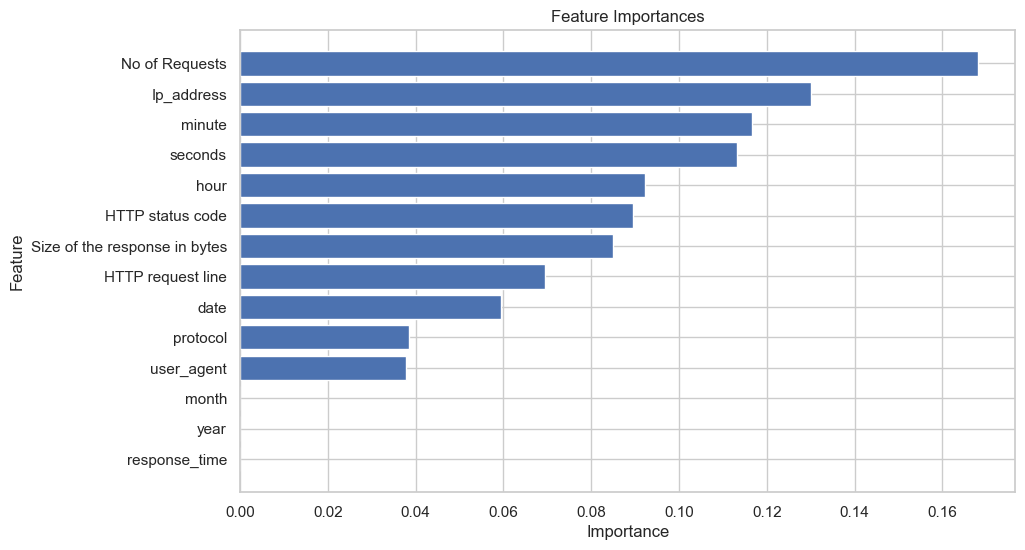

In [30]:
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
# Load the data
log_pandas_df = pd.read_csv('Anomaly1.csv')

# Select the columns you want to use for anomaly detection
selected_columns = ['Ip_address', 'HTTP request line', 'user_agent', 'protocol', 'HTTP status code',
                    'Size of the response in bytes', 'response_time', 'year', 'month', 'date', 'hour',
                    'minute', 'seconds', 'No of Requests']

# Prepare the target labels
y = log_pandas_df['IsAnomaly']

# Create a subset of the data
X = log_pandas_df[selected_columns]

# Create a RandomForestClassifier model
model = RandomForestClassifier(random_state=42)

# Fit the model on the entire dataset
model.fit(X, y)

# Get feature importances
feature_importances = model.feature_importances_

# Create a DataFrame to display feature importances
importance_df = pd.DataFrame({'Feature': selected_columns, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=True)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.show()


## Again Check Accuraccy Droping feature with less importance

In [31]:
# Load the data
log_pandas_df = pd.read_csv('Anomaly1.csv')

# Select the columns you want to use for anomaly detection
selected_columns = ['Ip_address', 'HTTP request line',  'protocol', 'HTTP status code',
                    'Size of the response in bytes','date', 'hour',
                    'minute', 'seconds', 'No of Requests']
data_subset = log_pandas_df[selected_columns]

# Prepare the target labels
y = log_pandas_df['IsAnomaly']

# Split the data into training and testing sets
X_train1, X_test1, y_train1, y_test1 = train_test_split(data_subset, y, test_size=0.2, random_state=42)

# Apply standard scaling to the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train1)
X_test_scaled = scaler.transform(X_test1)

# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_resampled2, y_train_resampled2 = smote.fit_resample(X_train_scaled, y_train1)

# Models to evaluate
algorithms = [
    ('Random Forest', RandomForestClassifier(random_state=42)),
    ('XGBoost', XGBClassifier(random_state=42)),
    ('Support Vector Machine', SVC(random_state=42)),
    ('Logistic Regression', LogisticRegression(random_state=42))
    # Add other algorithms here
]

for name, model in algorithms:
    print(f"Fitting {name}...")
    # Fit the model to the resampled training data
    model.fit(X_train_resampled2, y_train_resampled2)

    # Predict anomaly labels on the scaled test data
    predicted_labels = model.predict(X_test_scaled)

    # Generate a classification report
    classification_rep = classification_report(y_test1, predicted_labels)

    # Compute the confusion matrix
    conf_matrix = confusion_matrix(y_test1, predicted_labels)

    # Compute the Matthews Correlation Coefficient (MCC) score
    mcc = matthews_corrcoef(y_test1, predicted_labels)

    print(f"Classification Report for {name}:\n{classification_rep}")
    print(f"Confusion Matrix for {name}:\n{conf_matrix}")
    print(f"MCC Score for {name}: {mcc}\n")

Fitting Random Forest...
Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       0.95      0.92      0.94       780
           1       0.85      0.90      0.87       368

    accuracy                           0.92      1148
   macro avg       0.90      0.91      0.90      1148
weighted avg       0.92      0.92      0.92      1148

Confusion Matrix for Random Forest:
[[721  59]
 [ 38 330]]
MCC Score for Random Forest: 0.8096001347719144

Fitting XGBoost...
Classification Report for XGBoost:
              precision    recall  f1-score   support

           0       0.93      0.94      0.93       780
           1       0.87      0.86      0.86       368

    accuracy                           0.91      1148
   macro avg       0.90      0.90      0.90      1148
weighted avg       0.91      0.91      0.91      1148

Confusion Matrix for XGBoost:
[[731  49]
 [ 53 315]]
MCC Score for XGBoost: 0.7954668002357856

Fitting Support Vector

In [33]:
import optuna

# Hyperparameter tuning for Random Forest using Optuna
def rf_objective(trial):
    rf_params = {
        'n_estimators': trial.suggest_int('n_estimators', 50,500),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_categorical('max_features', ['auto', 'sqrt']),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False])
    }

    rf_model = RandomForestClassifier(**rf_params, random_state=42)
    rf_model.fit(X_train_resampled2, y_train_resampled2)

    # Predict anomaly labels on the scaled test data
    predicted_labels = rf_model.predict(X_test_scaled)

    # Compute the Matthews Correlation Coefficient (MCC) score
    mcc = matthews_corrcoef(y_test1, predicted_labels)

    return mcc

rf_study = optuna.create_study(direction='maximize')
rf_study.optimize(rf_objective, n_trials=50)

best_rf_params = rf_study.best_params
print("Best Parameters for Random Forest:", best_rf_params)

# Re-fit the best Random Forest model with the optimal parameters
best_rf_model = RandomForestClassifier(**best_rf_params, random_state=42)
best_rf_model.fit(X_train_resampled2, y_train_resampled2)

# Predict with the best Random Forest model
best_rf_predicted_labels = best_rf_model.predict(X_test_scaled)

# Generate a classification report for the best Random Forest model
best_rf_classification_rep = classification_report(y_test1, best_rf_predicted_labels)

# Hyperparameter tuning for XGBoost using Optuna
def xgb_objective(trial):
    xgb_params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'min_child_weight': trial.suggest_float('min_child_weight', 1, 10)
    }

    xgb_model = XGBClassifier(**xgb_params, random_state=42)
    xgb_model.fit(X_train_resampled2, y_train_resampled2)

    # Predict anomaly labels on the scaled test data
    predicted_labels = xgb_model.predict(X_test_scaled)

    # Compute the Matthews Correlation Coefficient (MCC) score
    mcc = matthews_corrcoef(y_test1, predicted_labels)

    return mcc

xgb_study = optuna.create_study(direction='maximize')
xgb_study.optimize(xgb_objective, n_trials=50)

best_xgb_params = xgb_study.best_params
print("Best Parameters for XGBoost:", best_xgb_params)

# Re-fit the best XGBoost model with the optimal parameters
best_xgb_model = XGBClassifier(**best_xgb_params, random_state=42)
best_xgb_model.fit(X_train_resampled2, y_train_resampled2)

# Predict with the best XGBoost model
best_xgb_predicted_labels = best_xgb_model.predict(X_test_scaled)

# Generate a classification report for the best XGBoost model
best_xgb_classification_rep = classification_report(y_test1, best_xgb_predicted_labels)

# Print the final classification reports
print("\nBest Random Forest Model:")
print(f"Best Random Forest MCC Score: {matthews_corrcoef(y_test1, best_rf_predicted_labels)}")
print(f"Classification Report for Best Random Forest Model:\n{best_rf_classification_rep}")

print("\nBest XGBoost Model:")
print(f"Best XGBoost MCC Score: {matthews_corrcoef(y_test1, best_xgb_predicted_labels)}")
print(f"Classification Report for Best XGBoost Model:\n{best_xgb_classification_rep}")


ModuleNotFoundError: No module named 'optuna'

In [ ]:
from sklearn import set_config
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, matthews_corrcoef

# Load the data
log_pandas_df = pd.read_csv('output12.csv')

# Select the columns you want to use for anomaly detection
selected_columns = ['Ip_address', 'HTTP request line', 'user_agent', 'protocol', 'HTTP status code',
                    'Size of the response in bytes', 'response_time', 'year', 'month', 'date', 'hour',
                    'minute', 'seconds', 'No of Requests']
data_subset = log_pandas_df[selected_columns]

# Prepare the target labels
y = log_pandas_df['IsAnomaly']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data_subset, y, test_size=0.2, random_state=42)

# Create a pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Apply standard scaling
    ('classifier', RandomForestClassifier(random_state=42))
])

# Fit the pipeline on the training data
pipeline.fit(X_train, y_train)

# Visualize the pipeline
set_config(display='diagram')
pipeline


FileNotFoundError: [Errno 2] No such file or directory: 'output12.csv'

In [35]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, matthews_corrcoef
import joblib

# Load the data
log_pandas_df = pd.read_csv('Anomaly1.csv')

# Select the columns you want to use for anomaly detection
selected_columns = ['Ip_address', 'HTTP request line',  'protocol', 'HTTP status code',
                    'Size of the response in bytes', 'date', 'hour',
                    'minute', 'seconds', 'No of Requests']
data_subset = log_pandas_df[selected_columns]

# Prepare the target labels
y = log_pandas_df['IsAnomaly']

# Split the data into training and testing sets
X_train1, X_test1, y_train1, y_test1 = train_test_split(data_subset, y, test_size=0.2, random_state=42)

# Apply standard scaling to the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train1)
X_test_scaled = scaler.transform(X_test1)

# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_resampled2, y_train_resampled2 = smote.fit_resample(X_train_scaled, y_train1)

# After training the Random Forest model
random_forest_model = RandomForestClassifier(random_state=42)
random_forest_model.fit(X_train_resampled2, y_train_resampled2)

# Save the Random Forest model to a file using joblib
model_filename = 'random_forest_model.joblib'
joblib.dump(random_forest_model, model_filename)
print(f"Random Forest model saved as {model_filename}")

# Load the Random Forest model from the saved file
loaded_random_forest_model = joblib.load(model_filename)

# Predict anomaly labels on the scaled test data using the loaded model
predicted_labels = loaded_random_forest_model.predict(X_test_scaled)

# Generate a classification report
classification_rep = classification_report(y_test1, predicted_labels)

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test1, predicted_labels)

# Compute the Matthews Correlation Coefficient (MCC) score
mcc = matthews_corrcoef(y_test1, predicted_labels)

print(f"Classification Report for Random Forest:\n{classification_rep}")
print(f"Confusion Matrix for Random Forest:\n{conf_matrix}")
print(f"MCC Score for Random Forest: {mcc}\n")


Random Forest model saved as random_forest_model.joblib
Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       0.95      0.92      0.94       780
           1       0.85      0.90      0.87       368

    accuracy                           0.92      1148
   macro avg       0.90      0.91      0.90      1148
weighted avg       0.92      0.92      0.92      1148

Confusion Matrix for Random Forest:
[[721  59]
 [ 38 330]]
MCC Score for Random Forest: 0.8096001347719144



In [37]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, matthews_corrcoef
import pickle

# Load the data
log_pandas_df = pd.read_csv('Anomaly1.csv')

# Select the columns you want to use for anomaly detection
selected_columns = ['Ip_address', 'HTTP request line',  'protocol', 'HTTP status code',
                    'Size of the response in bytes', 'date', 'hour',
                    'minute', 'seconds', 'No of Requests']
data_subset = log_pandas_df[selected_columns]

# Prepare the target labels
y = log_pandas_df['IsAnomaly']

# Split the data into training and testing sets
X_train1, X_test1, y_train1, y_test1 = train_test_split(data_subset, y, test_size=0.2, random_state=42)

# Apply standard scaling to the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train1)
X_test_scaled = scaler.transform(X_test1)

# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_resampled2, y_train_resampled2 = smote.fit_resample(X_train_scaled, y_train1)

# After training the Random Forest model
random_forest_model = RandomForestClassifier(random_state=42)
random_forest_model.fit(X_train_resampled2, y_train_resampled2)

# Save the Random Forest model to a file using pickle
model_filename = 'random_forest_model.pkl'
with open(model_filename, 'wb') as model_file:
    pickle.dump(random_forest_model, model_file)

print(f"Random Forest model saved as {model_filename}")

# Load the Random Forest model from the saved file
with open(model_filename, 'rb') as model_file:
    loaded_random_forest_model = pickle.load(model_file)

# Predict anomaly labels on the scaled test data using the loaded model
predicted_labels = loaded_random_forest_model.predict(X_test_scaled)

# Generate a classification report
classification_rep = classification_report(y_test1, predicted_labels)

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test1, predicted_labels)

# Compute the Matthews Correlation Coefficient (MCC) score
mcc = matthews_corrcoef(y_test1, predicted_labels)

print(f"Classification Report for Random Forest:\n{classification_rep}")
print(f"Confusion Matrix for Random Forest:\n{conf_matrix}")
print(f"MCC Score for Random Forest: {mcc}\n")


Random Forest model saved as random_forest_model.pkl
Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       0.95      0.92      0.94       780
           1       0.85      0.90      0.87       368

    accuracy                           0.92      1148
   macro avg       0.90      0.91      0.90      1148
weighted avg       0.92      0.92      0.92      1148

Confusion Matrix for Random Forest:
[[721  59]
 [ 38 330]]
MCC Score for Random Forest: 0.8096001347719144



In [36]:
import joblib

In [37]:
model=joblib.load("random_forest_model.pkl")

/Users/arpit/anaconda3/lib/python3.10/site-packages/sklearn/base.py:299: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.2.2 when using version 1.2.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/arpit/anaconda3/lib/python3.10/site-packages/sklearn/base.py:299: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 1.2.2 when using version 1.2.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [38]:
string="143.244.50.172 - - [16/Feb/2023:03:28:45 +0530] "GET /config/getuser?index=0 HTTP/1.1" 400 248 "-" "Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:76.0) Gecko/20100101 Firefox/76.0"
l1=[]
l1.append(" ".split(string))

SyntaxError: unterminated string literal (detected at line 1) (402222965.py, line 1)

In [6]:
l

[[' ']]

In [39]:
model.predict([[2415145644,4,6,143,248,16,3,28,45,62]])[0]

1

In [40]:
import pickle

In [45]:
pickle_out = open("RandomForestClassifier.pkl","wb")
pickle.dump(RandomForestClassifier, pickle_out)
pickle_out.close()

In [46]:
import numpy as np

In [55]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier

# Create a data sample
data = np.array([[2415145644,4,6,143,248,16,3,28,45,62]])

# Create a label sample
labels = np.array([1])

# Create a classifier
clf = RandomForestClassifier()

# Fit the classifier to the data
clf.fit(data, labels)

# Predict the class of the first data point
prediction = clf.predict(data)[0]


In [58]:
print(prediction)

1
